In [1]:
import datetime
import pandas as pd
from influxdb import DataFrameClient
import matplotlib
import matplotlib.pyplot as plt
import json
import pytz
import numpy as np
from sklearn.linear_model import LinearRegression
import yaml
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor


import sys
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler

ImportError: cannot import name 'traizzn_test_split' from 'sklearn.model_selection' (/Users/lazlopaul/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/__init__.py)

In [ ]:
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [ ]:
with open('uuid_map.json') as fp:
    uuid_map = json.load(fp)

In [ ]:
with open('config.yaml') as fp:
    config = yaml.safe_load(fp)
database_config = config.get('database')

In [ ]:
print(database_config)

In [ ]:
database_config.get('ssl')

In [10]:
client = DataFrameClient(
    host=database_config.get('host'), 
    port=database_config.get('port'), 
    username=database_config.get('username'), 
    password=database_config.get('password'), 
    database=database_config.get('database'), 
    ssl=database_config.get('ssl'), 
    verify_ssl=database_config.get('verify_ssl')
)

In [11]:
tz_local = pytz.timezone('America/Los_Angeles')
tz_utc = pytz.timezone('UTC')

In [12]:
uuid_dict = {
    'building_power': uuid_map['xbos/wattnode/building_main/PowerSum'],
    'freezer_power': uuid_map['xbos/wattnode/fre_comp_evapfan/PowerSum'],
    'ref_comp_power': uuid_map['xbos/wattnode/ref_comp/PowerSum'],
    'ref_fan_power': uuid_map['xbos/wattnode/ref_evapfan/PowerSum'],
    'hvac_west_power': uuid_map['xbos/wattnode/hvac_west_comp/PowerSum'],
    'hvac_east_power': uuid_map['xbos/wattnode/hvac_east_comp/PowerSum'],
    'pv_generation_power': 'd4102860-1f55-5e14-b02d-8bdb9e987676',
    'current_stored_energy_power': 'b5619f4e-b83d-567c-a197-254d36a9e885',
    
    'east_temperature': uuid_map['xbos/flexstat/thermostat_east/space_temp'],
    'west_temperature': uuid_map['xbos/flexstat/thermostat_west/space_temp'],
    'freezer_temperature': uuid_map['xbos/parker/freezer/CabinetTemperature'],
    'ref_temperature': uuid_map['xbos/parker/refrigerator/CabinetTemperature'],
    
    'east_heating_sp': uuid_map['xbos/flexstat/thermostat_east/active_heating_setpt'],
    'east_cooling_sp': uuid_map['xbos/flexstat/thermostat_east/active_cooling_setpt'],
    'west_heating_sp': uuid_map['xbos/flexstat/thermostat_west/active_heating_setpt'],
    'west_cooling_sp': uuid_map['xbos/flexstat/thermostat_west/active_cooling_setpt'],
    'freezer_sp': uuid_map['xbos/parker/freezer/Setpoint'],
    'ref_sp': uuid_map['xbos/parker/refrigerator/Setpoint'],
    
    'soc_battery': '0efc4fa5-755c-5c45-863a-c0c776ab7538',
    'setpoint_battery': '276ea28f-0f74-5b3e-9ad1-f3b9f747dbe4',
    'pv_generation_battery': 'fdfd7bbb-d2da-5b11-a8fa-58b231ab9802',
    
    'oat_current': 'f7c1f2c8-c996-528c-ab3d-bdc96dc9cf72',
    'humidity_current': '7967b372-2699-57e1-bc15-7861bfe6d024',
    'windspeed_current': 'ac555599-0403-5bea-8441-f39a4e8e0dac',
    'cloudcover_current': '6cce3e9a-3822-551b-b13c-f4b874f3afa1',
    'solar_current': 'd15979be-7a63-5230-9e7b-d068d9f40b08',
    'sr_current': 'd15979be-7a63-5230-9e7b-d068d9f40b08',
    
    'oat_forecast': '69be4db0-48f5-592f-b5a1-e2e695f28ad1',
    'humidity_forecast': 'c2379487-3df3-5bfe-bd8d-5992d2381ed5',
    'windspeed_forecast': '837d0588-b30a-56ee-920f-cf366fa0871f',
    'cloudcover_forecast': '6f93857f-50a6-5b9f-8b94-0231f511b382',
    'solar_forecast': 'a8357adb-c59d-5316-a0e8-51d2b2948c75',
    
    'price_energy_dr': '3be4c234-a38a-5e73-9d53-4503751592be',
    'price_demand_dr': '90928e8d-df40-5e75-9ddb-7ee444bc187f',
    'pmax_dr': '522605a9-77b1-57e3-9fac-06dd83ab8e89',
    'pmin_dr': '6b42adf8-3a48-5ae7-bdc3-19226e602865'
    
}

In [13]:
def parse_dt_utc(dt):
    return tz_local.localize(datetime.datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")).astimezone(tz_utc)

In [14]:
def current_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [15]:
def forecast_uuid_data(client, uuid, st, et, column_name):
    st_utc = parse_dt_utc(st).strftime("%Y-%m-%dT%H:%M:%SZ")
    et_utc = parse_dt_utc(et).strftime("%Y-%m-%dT%H:%M:%SZ")
    query = "select value from timeseries where \"uuid\" = '%s' and \"prediction_step\" = '1' and time>= '%s' and time <= '%s'" % (uuid, st_utc, et_utc)
    df = client.query(query)['timeseries']
    df = df[['value']]
    df.columns = [column_name]
    return df

In [16]:
def get_data_section(client, endswith, st, et, uuid_dict, resample='1T', current=True):
    df_list = []
    for variable in uuid_dict:
        if variable.endswith(endswith):
            uuid = uuid_dict[variable]
            if current:
                df = current_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            else:
                df = forecast_uuid_data(client, uuid, st, et, column_name=variable[:variable.rfind('_')])
            df = df.resample(resample).mean()
            df_list.append(df)
    return pd.concat(df_list, axis=1)

In [18]:
def get_power(st,et): #on 15 minute basis now
    df = get_data_section(client, '_power', st, et, uuid_dict, '1T')
    df = df.tz_convert(tz_local).tz_localize(None).resample('1T').mean()
    return df
#power_df=get_power(st,et)
#power_df.head()


In [19]:
#power_df.loc[~power_df['pv_generation'].isna()]

In [20]:
def get_weather(st, et):
    df = get_data_section(client, '_current', st, et, uuid_dict, '1T')
    df = df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear')#.resample('15T').mean()
    return df
#weather_df=get_weather(st,et)
#weather_df.head()

In [21]:
def get_pvgen(st, et):
    df = get_data_section(client, '_power', st, et, uuid_dict, '1T')
    df = df.tz_convert(tz_local).tz_localize(None).resample('1T').mean().interpolate('linear').resample('30T').mean()['pv_generation']
    return df
#PV=get_pvgen(st, et)

In [23]:
def adcols(pow_df,we_df):
    pow_df['uncontrolled']=pow_df['building']-pow_df['freezer']-pow_df['ref_comp']-pow_df['ref_fan']-pow_df['hvac_west']-pow_df['hvac_east']
    pow_df['hvacr']=pow_df['building']-pow_df['uncontrolled']
    newt = pow_df[['hvacr', 'uncontrolled','building']].copy()
    newt['rf'] = pow_df['freezer']+pow_df['ref_comp']+pow_df['ref_fan']
    newt['hvac']=pow_df['hvac_west']+pow_df['hvac_east'] 
    newt['oat'] = we_df['oat']
    newt['sr'] = we_df['sr']
    newt['solar']=we_df['solar']
    # X.net_load = X.net_load - X.pv
    # X = X.drop(columns=['pv']).dropna().resample('30T').mean()
    #display(newt)
    newt = newt.dropna().resample('15T').mean()
    newt['tod'] = newt.index.hour * 60 + newt.index.minute
    newt['dow'] = newt.index.weekday
    return newt

In [32]:
def add_batt_cols(X): 
    max_battery_rate = 21000
    min_battery_rate = -21000
    max_battery_soc = 0.95
    min_battery_soc = 0.25
    historical_data_interval_minutes = 15
    battery_total_capacity = 40500
    
    X['solar'] = X.sr * 272.6 * 0.26 * 0.98
    battery_df = X[['building', 'solar']]
    battery_df['building_pv'] = battery_df.building - battery_df.solar
    battery_df['soc'] = 0.5
    battery_df['battery_power'] = 0
    battery_df = battery_df.dropna()
    
    battery_df['time'] = (battery_df.index.hour + battery_df.index.minute/60 + battery_df.index.second/3600)
    battery_df.time = round(battery_df.time, 2)
    battery_df.head()
    
    prev_soc = -1
    prev_setpoint = 0
    for idx, row in battery_df.iterrows():
        if idx.time() == datetime.time(0,0,0):
            prev_soc = 0.5
            prev_setpoint = 0

        battery_soc = prev_soc  + prev_setpoint*5/60/battery_total_capacity
        battery_df.loc[idx, 'soc'] = battery_soc
        hour_now = row['time']
        net_load = row['building_pv']

        if idx.hour >= 0 and idx.hour <= 5:
            battery_setpoint = (max_battery_soc - battery_soc)*battery_total_capacity/(6-hour_now)
            if battery_setpoint > max_battery_rate:
                battery_setpoint = max_battery_rate
        elif net_load < 0:
            if battery_soc < max_battery_soc:
                if abs(net_load) > max_battery_rate:
                    battery_setpoint = max_battery_rate
                else:
                    battery_setpoint = abs(net_load)
            else:
                battery_setpoint = 0
        elif net_load > 0:
            if battery_soc > min_battery_soc:
                if (-1*net_load) < min_battery_rate:
                    battery_setpoint = min_battery_rate
                else:
                    battery_setpoint = -1*net_load
            else:
                battery_setpoint = 0

        battery_df.loc[idx, 'battery_power'] = battery_setpoint 
        prev_setpoint = battery_setpoint
        prev_soc = battery_soc
        
    X = X.join(battery_df[['soc', 'battery_power']])
        
    return X

<ipython-input-32-dbfbd7e49bfd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['building_pv'] = battery_df.building - battery_df.solar
<ipython-input-32-dbfbd7e49bfd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['soc'] = 0.5
<ipython-input-32-dbfbd7e49bfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [37]:
def metrics(df,df2):
    #means=df2.mean()
    #stds=df2.std()
    #train=(df2.copy()-means)/stds
    train=df2.copy()

    test=df.copy().dropna()
#    display(test.head())
    Xtest=test[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
    ytest=test[['hvacr']].dropna()

    Xtr=train[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
    ytr=train[['hvacr']].dropna()
    
#    display(Xtr.head())

    linres = LinearRegression().fit(Xtr,ytr)
    linregy=linres.predict(Xtest)

    RFres=RandomForestRegressor().fit(Xtr, ytr.values.ravel())
    ypred=RFres.predict(Xtest)
    
#     test['lin_pred']=linregy*stds['hvacr']+means['hvacr']
#     test['RF_pred']=ypred.reshape(-1,1)*stds['hvacr']+means['hvacr']
    
    test['lin_pred']=linregy
    test['RF_pred']=ypred

    test['lin_E']=test['lin_pred'].cumsum()
    test['RF_E']=test['RF_pred'].cumsum()
    test['E']=(test['hvacr']).cumsum()

    linErr.append(abs(test['E'].iloc[-1]-test['lin_E'].iloc[-1])/test['E'].iloc[-1]*100)
    RFErr.append(abs(test['E'].iloc[-1]-test['RF_E'].iloc[-1])/test['E'].iloc[-1]*100)

    lin_EMAPE.append(mape(test['E'],test['lin_E']))
#    print(mape(test['E'],test['lin_E']))
    RF_EMAPE.append(mape(test['E'],test['RF_E']))
    
    lin_MAPE.append(mape(test['hvacr'],test['lin_pred']))
    RF_MAPE.append(mape(test['hvacr'],test['RF_pred']))
    RF_Mdiff.append((-test['hvacr']+test['RF_pred']).mean())
    p_errors.append(mpe(test['hvacr'],test['RF_pred']))
    RF_E_err.append((test['E'].iloc[-1]-test['RF_E'].iloc[-1])/test['E'].iloc[-1]*100)
    
    sts=test.index[0].strftime('%Y-%m-%d %H:%M:%S')
    ets=test.index[-1].strftime('%Y-%m-%d %H:%M:%S')
    print(sts)
    print(ets)
    
    plt.plot(test['lin_pred'], label='linear')
    plt.plot(test['RF_pred'], label='RF')
    plt.plot(test['hvacr'], label='real')
    plt.legend()
    plt.show()
#    print(RF_Mdiff)
    return lin_EMAPE, RF_EMAPE, linErr, RFErr, RF_MAPE, lin_MAPE, RF_Mdiff, p_errors, RF_E_err

In [33]:
def mape(yt, yp): 
    return np.mean((np.abs(yt - yp)) / yp) * 100

In [34]:
def mpe(yt, yp): 
    return np.mean(((yt - yp)) / yp) * 100

In [35]:
def CrossValScore(X,y,model):
    splitter = KFold(n_splits=20, shuffle=True)
    return np.mean(cross_val_score(model, X, y, cv=splitter))

In [108]:
# Bsts=["2020-07-28 00:00:00",'2020-08-06 00:00:00', '2020-08-08 00:00:00', '2020-08-10 00:00:00', '2020-08-12 00:00:00', '2020-08-14 00:00:00', '2020-08-17 00:00:00', '2020-08-27 00:00:00', '2020-08-29 00:00:00', '2020-09-04 00:00:00']
# Bets=["2020-08-02 23:59:59",'2020-08-06 23:59:59', '2020-08-08 23:59:59', '2020-08-10 23:59:59', '2020-08-12 23:59:59', '2020-08-14 23:59:59', '2020-08-26 00:00:00', '2020-08-27 23:59:59', '2020-08-29 23:59:59', '2020-09-17 00:00:00']

Bsts=["2020-07-19 00:00:00",'2020-08-06 00:00:00', '2020-08-08 00:00:00', '2020-08-10 00:00:00', '2020-08-12 00:00:00', '2020-08-14 00:00:00', '2020-08-17 00:00:00', '2020-08-27 00:00:00', '2020-08-29 00:00:00', '2020-09-04 00:00:00']
Bets=["2020-08-02 23:59:59",'2020-08-06 23:59:59', '2020-08-08 23:59:59', '2020-08-10 23:59:59', '2020-08-12 23:59:59', '2020-08-14 23:59:59', '2020-08-26 00:00:00', '2020-08-27 23:59:59', '2020-08-29 23:59:59', '2020-09-17 00:00:00']



In [109]:
#st = "2020-07-19 00:00:00"
#et = "2020-08-02 23:59:59"

In [110]:
#X=adcols(power_df,weather_df)

In [111]:
#len(X)

In [133]:
B={}
PV={}
for i,b in enumerate(Bsts):
    pow_df=get_power(Bsts[i],Bets[i])
    we_df=get_weather(Bsts[i],Bets[i])
    pv_df=get_pvgen(Bsts[i],Bets[i])
    PV[i]=pv_df
    B[i]=adcols(pow_df,we_df)

In [134]:
X=disconts=pd.concat(B, axis=1).sum(axis=1, level=1)
#X=X.append(disconts)

In [135]:
X=add_batt_cols(X)

<ipython-input-32-dbfbd7e49bfd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['building_pv'] = battery_df.building - battery_df.solar
<ipython-input-32-dbfbd7e49bfd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['soc'] = 0.5
<ipython-input-32-dbfbd7e49bfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [136]:
len(X.index)

4223

In [137]:
copy=X.copy()

In [138]:
linErr=[]
lin_EMAPE=[]
RF_EMAPE=[]
RFErr=[]
RF_price_diff=[]
p_errors=[]
RF_Mdiff=[]
RF_E_err=[]

In [139]:
len(X.index)/48

87.97916666666667

In [141]:
#Normalization
StdDevs=X.std()

In [142]:
Means=X.mean()

In [143]:
Xnorm=(X-Means)/StdDevs

In [144]:
#X.loc[X['hvacr']+10000>=X['uncontrolled']]

don't make me do it https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf

2020-07-19 00:00:00
2020-07-20 23:45:00


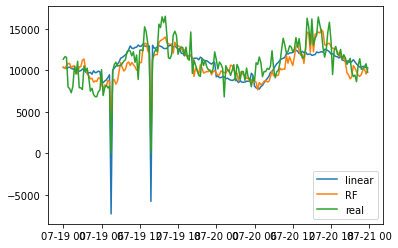

2020-07-21 00:00:00
2020-07-22 23:45:00


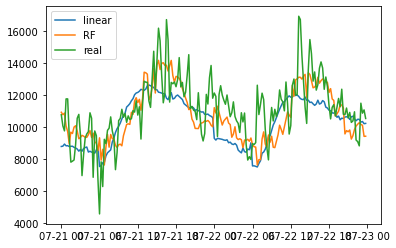

2020-07-23 00:00:00
2020-07-24 23:45:00


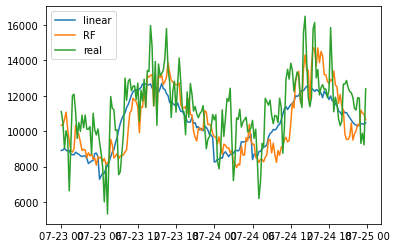

2020-07-25 00:00:00
2020-07-26 23:45:00


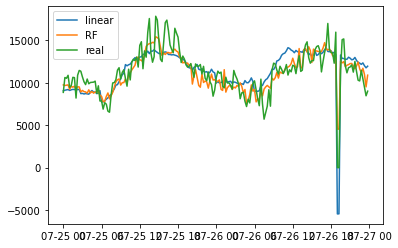

2020-07-27 00:00:00
2020-07-28 23:45:00


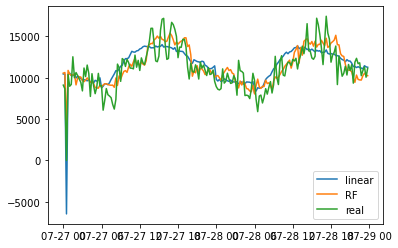

2020-07-29 00:00:00
2020-07-30 23:45:00


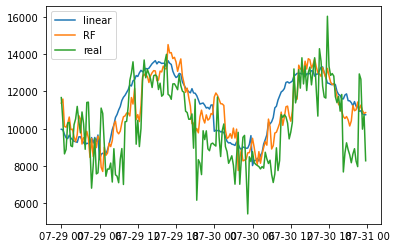

2020-07-31 00:00:00
2020-08-01 23:45:00


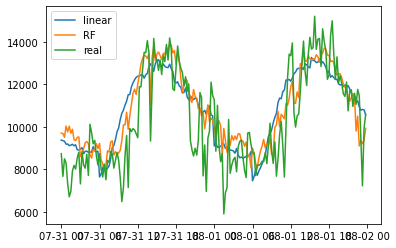

2020-08-02 00:00:00
2020-08-06 23:45:00


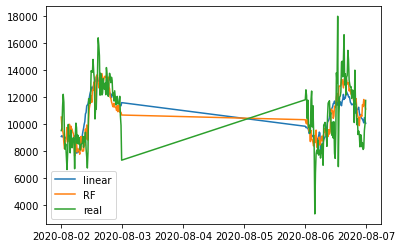

2020-08-08 00:00:00
2020-08-10 23:45:00


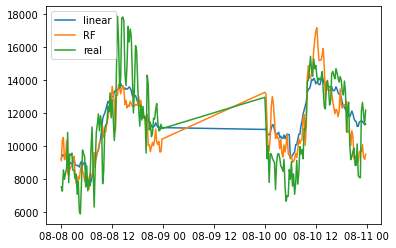

2020-08-12 00:15:00
2020-08-17 00:00:00


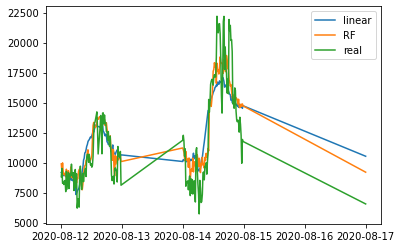

2020-08-17 00:15:00
2020-08-19 00:00:00


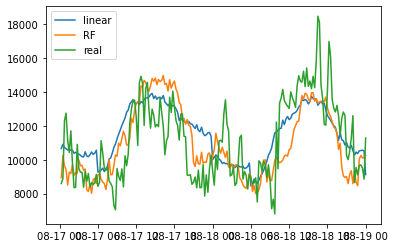

2020-08-19 00:15:00
2020-08-21 00:00:00


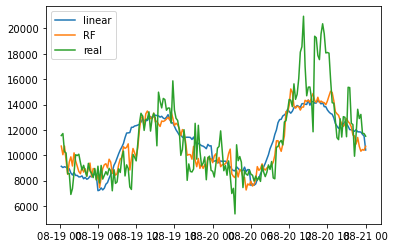

2020-08-21 00:15:00
2020-08-23 00:00:00


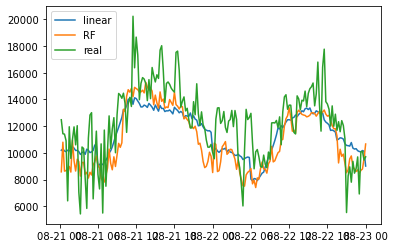

2020-08-23 00:15:00
2020-08-25 00:00:00


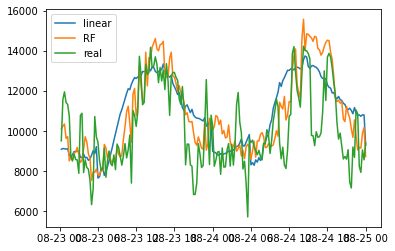

2020-08-25 00:15:00
2020-08-29 00:00:00


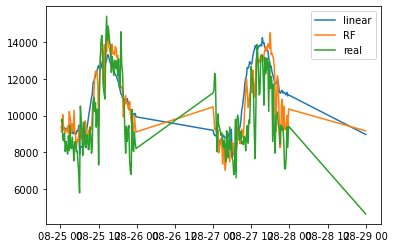

2020-08-29 00:15:00
2020-09-05 00:00:00


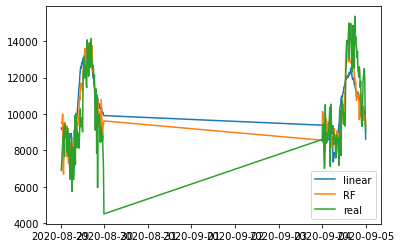

2020-09-05 00:15:00
2020-09-07 00:00:00


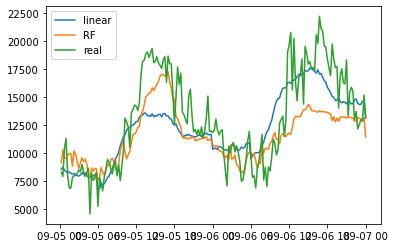

2020-09-07 00:15:00
2020-09-09 00:00:00


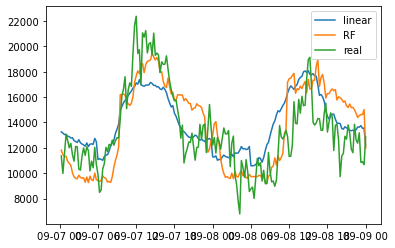

2020-09-09 00:15:00
2020-09-11 00:00:00


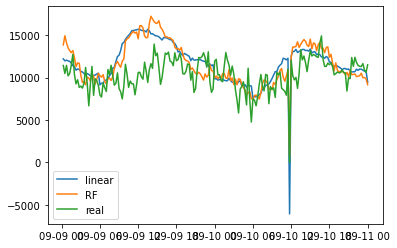

2020-09-11 00:15:00
2020-09-13 00:00:00


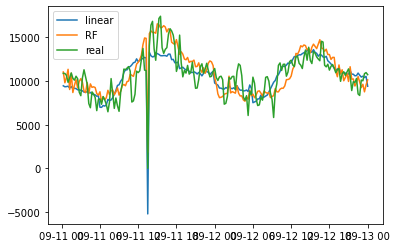

2020-09-13 00:15:00
2020-09-15 00:00:00


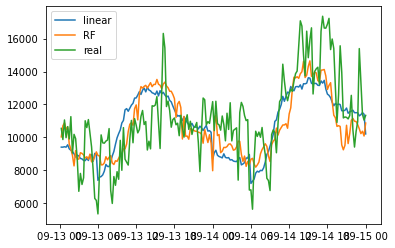

2020-09-15 00:15:00
2020-09-16 23:45:00


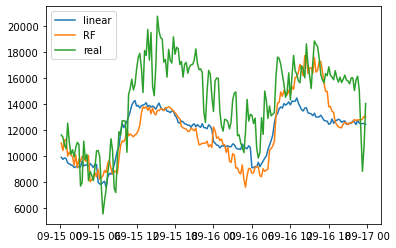

In [145]:
divs=round(len(X.index)/22)
linErr=[]
lin_EMAPE=[]
RF_EMAPE=[]
RFErr=[]
lin_MAPE=[]
RF_MAPE=[]
RF_Mdiff=[]
RF_price_diff=[]
p_errors=[]
RF_E_err=[]
for i in range(0,22):
    df=X.copy().iloc[i*divs:(i+1)*divs]
    df2=X.copy().iloc[0:i*divs].append(X.copy().iloc[(i+1)*divs:])
    #display(df2.head())
    lin_EMAPE, RF_EMAPE, linErr, RFErr, RF_MAPE, lin_MAPE, RF_Mdiff, p_errors,RF_E_err = metrics(df,df2)

In [146]:
print(np.array(lin_EMAPE).mean())
print(np.array(linErr).mean())
print(np.array(RF_EMAPE).mean())
print(np.array(RFErr).mean())
print(np.array(lin_MAPE).mean())
print(np.array(RF_MAPE).mean())
print(np.array(RF_Mdiff).mean())

6.300375166616132
5.312151149897319
5.933979302999223
5.115321634632087
13.196687728119882
13.210449505483645
-117.95293720997142


In [147]:
perr=np.array(p_errors)
E_err=np.array(RF_E_err)
print(perr.mean())

1.2398537928639797


3.9132471920813985 -4.11718559826198 0.4112711816279382 1.2398537928639797


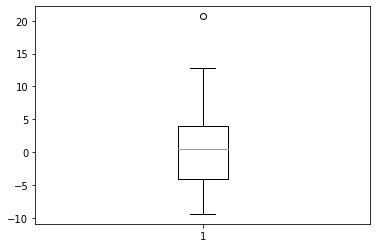

In [148]:
plt.boxplot(perr)
print(np.percentile(perr, 75), np.percentile(perr, 25), np.percentile(perr, 50), perr.mean())

## Calculating Prices funcs


In [149]:
def RCEAprice(df): #already made and with correct datetime index
    p_ind=df.reset_index()['index'].dt.time
    price_df=pd.DataFrame(p_ind)
    price_df['time']=price_df['index']
    price_df=price_df.drop(labels='index', axis=1)
    
    peakst=datetime.datetime.strptime('12:00','%H:%M').time()
    peaket=datetime.datetime.strptime('18:00','%H:%M').time()
    partpeakst=datetime.datetime.strptime('08:30','%H:%M').time()
    partpeaket=datetime.datetime.strptime('21:30','%H:%M').time()
    
    price_df.loc[(price_df['time'] >= peakst) & (price_df['time'] < peaket), 'price']= 0.11188/1000
    price_df.loc[(price_df['time'] >= peakst) & (price_df['time'] < peaket), 'tou']= 'peak'    # if (t>= '12:00:00') & (t<'18:00:00') else .06879 for t in price_df['Time']  ]
    price_df.loc[((price_df['time'] >= partpeakst) & (price_df['time'] < peakst)) | ((price_df['time'] >= peaket) & (price_df['time'] < partpeaket)), 'price']= 0.06879/1000
    price_df.loc[((price_df['time'] >= partpeakst) & (price_df['time'] < peakst)) | ((price_df['time'] >= peaket) & (price_df['time'] < partpeaket)), 'tou']= 'partpeak'
    price_df.loc[(~(price_df['time'] >= partpeakst) & (price_df['time'] < partpeaket)), 'price']= 0.04026/1000
    price_df.loc[(~(price_df['time'] >= partpeakst) & (price_df['time'] < partpeaket)), 'tou']= 'offpeak'
    
    df1=df.reset_index()
    df1['time']=p_ind
    df1['date']=df.reset_index()['index'].dt.date
    df2=df1.merge(price_df, how='left', on='time')
    df3=df2.set_index('index')
    
    return df3

In [150]:
def RCEAcost_info(df, col):
    info={}
    day=df.iloc[0].loc['date']
    info[day]={}
    
    df['building']=df['uncontrolled']+df[col]
    df['Pbal']=(df['uncontrolled']+df[col])-(-df['battery_power']+df['solar'])
    
    df['Ebal']=(df['Pbal']*0.25)
    info[day]['E from Grid']=(df['Ebal']).sum()
    info[day]['P during Part-Peak']=(df.loc[df['tou']=='partpeak']['Pbal']).max() #(df['building_draw']-(-df['c_battery_power']+df['solar'])).max()
    info[day]['P during Peak']=(df.loc[df['tou']=='peak']['Pbal']).max()
    info[day]['P during Off-Peak']=(df.loc[df['tou']=='offpeak']['Pbal']).max()
    
    info[day]['E during Part-Peak']=((df.loc[df['tou']=='partpeak'])['Pbal']*0.25).sum()
    info[day]['E during Peak']=((df.loc[df['tou']=='peak'])['Pbal']*0.25).sum()
    info[day]['E during Off-Peak']=((df.loc[df['tou']=='offpeak'])['Pbal']*0.25).sum()
    
    
    info[day]['E from PV']=(df['solar']*0.25).sum() #15 minutes is 0.25 hours for kWh
    info[day]['E-Used']=(df['building']*0.25).sum()
    info[day]['Cost']=(df['Ebal']*df['price']).sum()+ info[day]['P during Peak']*13.44/1000 + info[day]['P during Part-Peak']*3.32/1000
    info[day]['Cost hvacr']=(df[col]*0.25*df['price']).sum()
    info[day]['Cost hvacr/mean oat']=info[day]['Cost hvacr']/df['oat'].mean()
    #info[day]['Cost HVACR*devation from comfortable temp/outdoor temp']
    info[day]['Cost/kWh Grid']=info[day]['Cost']/info[day]['E from Grid']
    #info[day]['Cost*kWh Solar']=info[day]['Cost']*info[day]['E from PV']
    info[day]['Cost/mean oat']=info[day]['Cost']/df['oat'].max()
    info[day]['mean temp']=df['oat'].mean()
    info[day]['max temp']=df['oat'].max()
    return pd.DataFrame(info)

In [151]:
def PGEprice(df): #already made and with correct datetime index
    p_ind=df.reset_index()['index'].dt.time
    price_df=pd.DataFrame(p_ind)
    price_df['time']=price_df['index']
    price_df=price_df.drop(labels='index', axis=1)
    
    peakst=datetime.datetime.strptime('16:00','%H:%M').time()
    peaket=datetime.datetime.strptime('21:00','%H:%M').time()
    partpeakst=datetime.datetime.strptime('14:00','%H:%M').time()
    partpeaket=datetime.datetime.strptime('23:00','%H:%M').time()
    
    price_df.loc[(price_df['time'] >= peakst) & (price_df['time'] < peaket), 'price']= 0.16285/1000
    price_df.loc[(price_df['time'] >= peakst) & (price_df['time'] < peaket), 'tou']= 'peak'    # if (t>= '12:00:00') & (t<'18:00:00') else .06879 for t in price_df['Time']  ]
    price_df.loc[((price_df['time'] >= partpeakst) & (price_df['time'] < peakst)) | ((price_df['time'] >= peaket) & (price_df['time'] < partpeaket)), 'price']= 0.13284/1000
    price_df.loc[((price_df['time'] >= partpeakst) & (price_df['time'] < peakst)) | ((price_df['time'] >= peaket) & (price_df['time'] < partpeaket)), 'tou']= 'partpeak'
    price_df.loc[(~(price_df['time'] >= partpeakst) & (price_df['time'] < partpeaket)), 'price']= 0.11162/1000
    price_df.loc[(~(price_df['time'] >= partpeakst) & (price_df['time'] < partpeaket)), 'tou']= 'offpeak'
    
    df1=df.reset_index()
    df1['time']=p_ind
    df1['date']=df.reset_index()['index'].dt.date
    df2=df1.merge(price_df, how='left', on='time')
    df3=df2.set_index('index')
    
    return df3

In [152]:
def PGEcost_info(df, col):
    info={}
    day=df.iloc[0].loc['date']
    info[day]={}
    
    df['building']=df['uncontrolled']+df[col]
    df['Pbal']=(df['uncontrolled']+df[col])-(-df['battery_power']+df['solar'])
    
    df['Ebal']=(df['Pbal']*0.25)
#    info[day]['E from Grid']=(df['Ebal']).sum()
    info[day]['P during Part-Peak']=(df.loc[df['tou']=='partpeak']['Pbal']).max() #(df['building_draw']-(-df['c_battery_power']+df['solar'])).max()
    info[day]['P during Peak']=(df.loc[df['tou']=='peak']['Pbal']).max()
    info[day]['P during Off-Peak']=(df.loc[df['tou']=='offpeak']['Pbal']).max()
    info[day]['Max P']=df['Pbal'].max()
    
    info[day]['E during Part-Peak']=((df.loc[df['tou']=='partpeak'])['Pbal']*0.25).sum()
    info[day]['E during Peak']=((df.loc[df['tou']=='peak'])['Pbal']*0.25).sum()
    info[day]['E during Off-Peak']=((df.loc[df['tou']=='offpeak'])['Pbal']*0.25).sum()
    
    info[day]['E from PV']=(df['solar']*0.25).sum() #15 minutes is 0.25 hours for kWh
    info[day]['E-Used']=(df['building']*0.25).sum()
    info[day]['Cost']=(df['Ebal']*df['price']).sum()+ info[day]['P during Peak']*13.44/1000 + info[day]['P during Part-Peak']*3.32/1000 + info[day]['Max P']*21.08/1000
    info[day]['Cost hvacr']=(df[col]*0.25*df['price']).sum()
#    info[day]['Cost hvacr/mean oat']=info[day]['Cost hvacr']/df['oat'].mean()
    #info[day]['Cost HVACR*devation from comfortable temp/outdoor temp']
#    info[day]['Cost/kWh Grid']=info[day]['Cost']/info[day]['E from Grid']
    #info[day]['Cost*kWh Solar']=info[day]['Cost']*info[day]['E from PV']
#    info[day]['Cost/mean oat']=info[day]['Cost']/df['oat'].max()
#    info[day]['mean temp']=df['oat'].mean()
#    info[day]['max temp']=df['oat'].max()
   
    return pd.DataFrame(info)

In [153]:
def RCEApricecomp(price_df):
    pred_cost=(RCEAcost_info(RCEAprice(price_df),'P_pred'))
    real_cost=(RCEAcost_info(RCEAprice(price_df),'hvacr'))

    cost_comp=pred_cost.copy()
    cost_comp.columns=['predicted']
    cost_comp['real']=real_cost.values
    cost_comp['percent_error']=-(cost_comp['predicted']-cost_comp['real'])/cost_comp['real']*100   #np.abs
    return cost_comp

In [154]:
def PGEpricecomp(price_df):
    pred_cost=(PGEcost_info(PGEprice(price_df),'P_pred'))
    real_cost=(PGEcost_info(PGEprice(price_df),'hvacr'))

    cost_comp=pred_cost.copy()
    cost_comp.columns=['predicted']
    cost_comp['real']=real_cost.values
    cost_comp['percent_error']=-(cost_comp['predicted']-cost_comp['real'])/cost_comp['real']*100   #np.abs
    return cost_comp

In [155]:
def crossVal_cost(df,df2):
    train=df2.copy()

    test=df.copy().dropna()

    Xtest=test[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
    ytest=test[['hvacr']].dropna()

    Xtr=train[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
    ytr=train[['hvacr']].dropna()


    RFres=RandomForestRegressor().fit(Xtr, ytr.values.ravel())
    ypred=RFres.predict(Xtest)


    test['P_pred']=ypred
    #test['RF_E']=test['RF_pred'].cumsum()
    test['E']=(test['hvacr']).cumsum()
    
    cDF=RCEApricecomp(test)
    
    #display(cDF)
    
    x=cDF['percent_error'][['Cost']].item()
    
    
    return x
    

In [156]:
Xp=X.copy()

In [157]:
Xvals=Xp[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
yvals=Xp[['hvacr']].dropna()

Xtrain=Xvals[:-48]
ytrain=yvals[:-48]

Xtest=Xvals[-48:]
ytest=yvals[-48:]

In [158]:
price_df=Xp.iloc[-48:].copy()

In [159]:
model=RandomForestRegressor().fit(Xtrain,ytrain.values.ravel())
price_df['P_pred']=model.predict(Xtest)
#price_df['E_pred']=price_df['P_pred'].cumsum()
#price_df['E']=price_df['hvacr'].cumsum()
price_df.head()

,hvacr,uncontrolled,building,rf,hvac,oat,sr,solar,tod,dow,soc,battery_power,P_pred
2020-09-16 12:00:00,14314.665205,22603.022881,36917.688086,3966.819209,10347.845996,75.161333,470.285852,32665.340423,720.0,2.0,0.223509,0.0,15678.693049
2020-09-16 12:15:00,16114.282535,24991.669028,41105.951562,5896.372720,10217.909814,75.086733,474.179708,32935.801791,735.0,2.0,0.223509,0.0,16438.706429
2020-09-16 12:30:00,17737.131136,23775.411122,41512.542259,7607.415005,10129.716131,75.623030,478.908937,33264.286800,750.0,2.0,0.223509,0.0,15974.369688
2020-09-16 12:45:00,16560.607887,24201.790160,40762.398047,6458.281496,10102.326392,75.374400,479.659265,33316.403464,765.0,2.0,0.223509,0.0,15848.046309
2020-09-16 13:00:00,16283.978944,26954.745132,43238.724077,6126.356008,10157.622936,74.927576,476.646026,33107.108456,780.0,2.0,0.223509,0.0,16334.324390


In [160]:
cost_comp=RCEApricecomp(price_df)
cost_comp['percent_error'][['Cost']].item()

5.775405720016856

In [161]:
cost_perror=[]
for i in range(0,22):
    df=Xp.copy().iloc[i*divs:(i+1)*divs]
    df2=Xp.copy().iloc[0:i*divs].append(X.copy().iloc[(i+1)*divs:])
    #display(df2.head())
    s= crossVal_cost(df, df2)
    cost_perror.append(s)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fe9f42924c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fe9f4292b80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fe9f4292160>],
 'medians': [<matplotlib.lines.Line2D at 0x7fe9f42c0100>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fe9f42c0580>],
 'means': []}

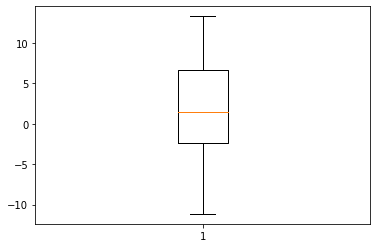

In [162]:
cost_perr=np.array(cost_perror)
plt.boxplot(cost_perr)

In [163]:

print(np.percentile(cost_perr, 75), np.percentile(cost_perr, 25), np.percentile(cost_perr, 50), cost_perr.mean())

6.586397976537748 -2.4159097986679265 1.448135916240025 2.043435090506067


## Bluesky vs Baseline

In [164]:
#model=RandomForestRegressor().fit(Xvals,yvals.values.ravel())


In [165]:
model=RandomForestRegressor().fit(Xvals,yvals.values.ravel())
def get_price_df(df):
    price_df=df.copy()
    dftest=df[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
    price_df['P_pred']=model.predict(dftest)
    price_df['E_pred']=price_df['P_pred'].cumsum()
    price_df['E']=price_df['hvacr'].cumsum()
    #price_df.head()
    return price_df

In [166]:
def pull_data(BSst,BSet):
    pow_df=get_power(BSst,BSet)
    we_df=get_weather(BSst,BSet)
    BS_df=add_batt_cols(adcols(pow_df,we_df))
    return BS_df

In [167]:
def barplot(df):
    RFEs=(df['predicted']['E during Peak'],df['predicted']['E during Part-Peak'], df['predicted']['E during Off-Peak'])
    Es=(df['real']['E during Peak'],df['real']['E during Part-Peak'], df['real']['E during Off-Peak'])
    
    RFPs=(df['predicted']['P during Peak'],df['predicted']['P during Part-Peak'], df['predicted']['P during Off-Peak'])
    Ps=(df['real']['P during Peak'],df['real']['P during Part-Peak'], df['real']['P during Off-Peak'])

    ind=np.arange(0,3)

    plt.bar(ind, RFEs, .35, label='Baseline (predicted)')
    plt.bar(ind + .35, Es, .35, label=get_df_name(df))

    plt.ylabel('Energy Used (Wh)')
    plt.title('Energy Use in Different Periods')

    plt.xticks(ind + .35 / 2, ('During Peak', 'During Part-Peak', 'During Off-Peak'))
    plt.legend(loc='best')
    plt.show()
    
    plt.bar(ind, RFPs, .35, label='Baseline (predicted)')
    plt.bar(ind + .35, Ps, .35, label=get_df_name(df))

    plt.ylabel('Powe used (W)')
    plt.title('Power Use in Different Periods')

    plt.xticks(ind + .35 / 2, ('During Peak', 'During Part-Peak', 'During Off-Peak'))
    plt.legend(loc='best')
    plt.show()

In [168]:
#Blue Sky E19
BSst='2020-08-11 00:00:00'
BSet='2020-08-11 23:59:59'

In [169]:
BS_df=pull_data(BSst,BSet)

<ipython-input-32-dbfbd7e49bfd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['building_pv'] = battery_df.building - battery_df.solar
<ipython-input-32-dbfbd7e49bfd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['soc'] = 0.5
<ipython-input-32-dbfbd7e49bfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [170]:
BS_price=get_price_df(BS_df)
RCEA=RCEApricecomp(BS_price)
display(RCEA)

,predicted,real,percent_error
Cost,337.343329,337.469344,0.037341
Cost hvacr,16.755905,16.260696,-3.045439
Cost hvacr/mean oat,0.275476,0.267335,-3.045439
Cost/kWh Grid,0.000747,0.000748,0.181053
Cost/mean oat,4.866106,4.867924,0.037341
E during Off-Peak,253902.641780,255499.197298,0.624877
E during Part-Peak,103157.505307,103797.610715,0.616686
E during Peak,12666.834919,7272.485597,-74.174768
E from Grid,451650.197913,451000.878827,-0.143973
E from PV,325837.752747,325837.752747,-0.000000


In [171]:
RFEs=(RCEA['predicted']['E during Peak'],RCEA['predicted']['E during Part-Peak'], RCEA['predicted']['E during Off-Peak'])
Es=(RCEA['real']['E during Peak'],RCEA['real']['E during Part-Peak'], RCEA['real']['E during Off-Peak'])

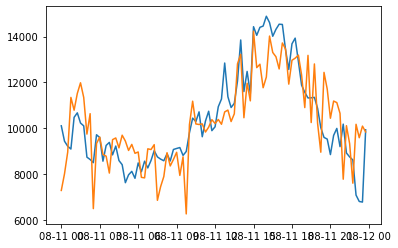

In [172]:
plt.plot(BS_price['P_pred'])
plt.plot(BS_price['hvacr'])

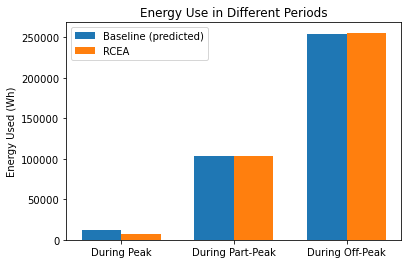

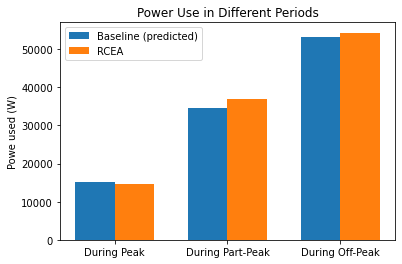

In [173]:
barplot(RCEA)

In [174]:
PGst='2020-08-13 00:00:00'
PGet='2020-08-13 23:59:59'

In [175]:
#PGE=pull_data(PGst,PGet)

In [176]:
PGE=pull_data(PGst,PGet)
PGE_df=PGEpricecomp(get_price_df(PGE))
PGE_df

<ipython-input-32-dbfbd7e49bfd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['building_pv'] = battery_df.building - battery_df.solar
<ipython-input-32-dbfbd7e49bfd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['soc'] = 0.5
<ipython-input-32-dbfbd7e49bfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,predicted,real,percent_error
Cost,1803.775224,1838.880395,1.909051
Cost hvacr,30.937528,31.539117,1.907438
E during Off-Peak,259911.314152,264748.301137,1.827013
E during Part-Peak,75407.635581,73943.265448,-1.980397
E during Peak,109218.701697,110792.000054,1.420047
E from PV,317712.429779,317712.429779,-0.000000
E-Used,830738.881758,834556.404423,0.457431
Max P,52773.342323,53390.270419,1.155507
P during Off-Peak,52773.342323,53390.270419,1.155507
P during Part-Peak,40925.558005,40417.919922,-1.255973


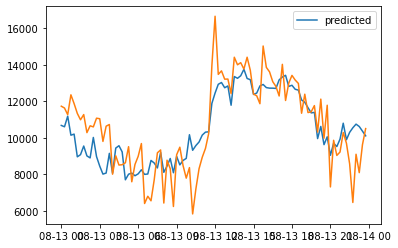

In [177]:
plt.plot(get_price_df(PGE)['P_pred'], label='predicted')
plt.plot(get_price_df(PGE)['hvacr'])
plt.legend()

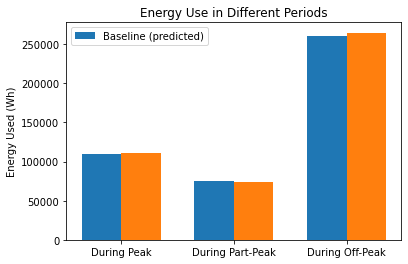

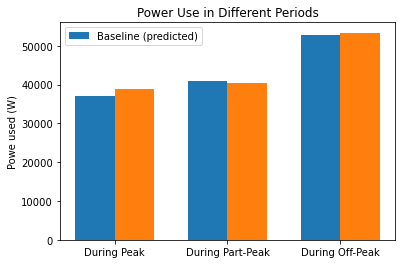

In [178]:
barplot(PGE_df)

## Demand Limiting and Load Shedding Metrics

In [179]:
DLst='2020-08-28 00:00:00'
DLet='2020-08-28 23:59:59'

In [180]:
DL=pull_data(DLst,DLet)
DL_df=PGEpricecomp(get_price_df(DL))
DL_df

<ipython-input-32-dbfbd7e49bfd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['building_pv'] = battery_df.building - battery_df.solar
<ipython-input-32-dbfbd7e49bfd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['soc'] = 0.5
<ipython-input-32-dbfbd7e49bfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,predicted,real,percent_error
Cost,1838.182535,1817.214990,-1.153829
Cost hvacr,32.574550,31.217032,-4.348645
E during Off-Peak,268665.621697,263094.404093,-2.117574
E during Part-Peak,80154.033631,77520.577518,-3.397106
E during Peak,128800.581465,126431.344553,-1.873932
E from PV,290191.773629,290191.773629,-0.000000
E-Used,832479.922054,821045.139750,-1.392711
Max P,52307.237287,52491.322443,0.350696
P during Off-Peak,52307.237287,52491.322443,0.350696
P during Part-Peak,38126.109147,37618.147266,-1.350311


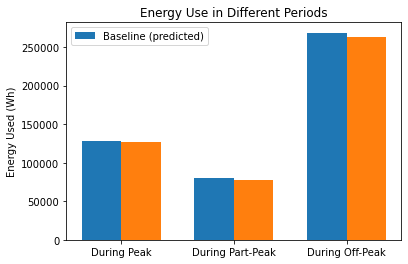

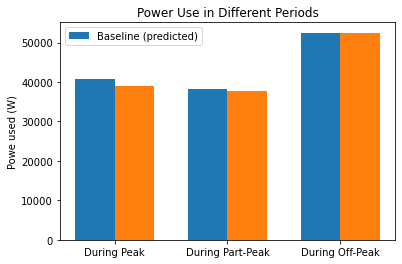

In [181]:
barplot(DL_df)

In [182]:
BLSst='2020-08-29 00:00:00'
BLSet='2020-08-29 23:59:59'
BLS=pull_data(BLSst,BLSet)
PGEpricecomp(get_price_df(BLS))

<ipython-input-32-dbfbd7e49bfd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['building_pv'] = battery_df.building - battery_df.solar
<ipython-input-32-dbfbd7e49bfd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['soc'] = 0.5
<ipython-input-32-dbfbd7e49bfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,predicted,real,percent_error
Cost,1765.311553,1773.895073,0.483880
Cost hvacr,29.385813,28.847350,-1.866593
E during Off-Peak,255498.057263,252558.263953,-1.164006
E during Part-Peak,73341.149524,72826.140127,-0.707177
E during Peak,115868.886411,114997.477111,-0.757764
E from PV,296676.932575,296676.932575,-0.000000
E-Used,803214.613147,798554.504617,-0.583568
Max P,52710.114348,52807.579688,0.184567
P during Off-Peak,52710.114348,52807.579688,0.184567
P during Part-Peak,34849.593485,34715.769336,-0.385485


In [183]:
LSst='2020-09-03 00:00:00'
LSet='2020-09-03 23:59:59'

In [184]:
LS=pull_data(LSst,LSet)
LS_df=PGEpricecomp(get_price_df(LS))
LS_df

<ipython-input-32-dbfbd7e49bfd>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['building_pv'] = battery_df.building - battery_df.solar
<ipython-input-32-dbfbd7e49bfd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  battery_df['soc'] = 0.5
<ipython-input-32-dbfbd7e49bfd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

,predicted,real,percent_error
Cost,1843.284391,1898.637672,2.915421
Cost hvacr,31.046479,30.420396,-2.058102
E during Off-Peak,285728.049106,287193.558558,0.510286
E during Part-Peak,83265.133855,81733.388540,-1.874075
E during Peak,131118.702878,127519.157472,-2.822749
E from PV,285072.652035,285072.652035,-0.000000
E-Used,853489.359481,851881.476054,-0.188745
Max P,54425.416227,55191.448686,1.387955
P during Off-Peak,54425.416227,55191.448686,1.387955
P during Part-Peak,38774.501823,40400.202344,4.023991


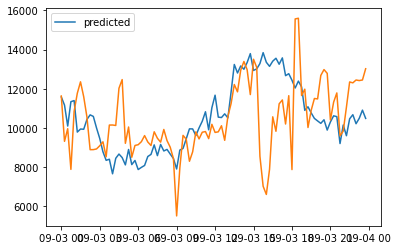

In [185]:
plt.plot(get_price_df(LS)['P_pred'], label='predicted')
plt.plot(get_price_df(LS)['hvacr'])
plt.legend()

## Testing different Linear Models

In [186]:
def crossVal_hvac_rf(df,df2):
    train=df2.copy()

    test=df.copy().dropna()

    Xtest=test[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
    ytest=test[['hvac']].dropna()
    

    Xtr=train[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].dropna()
    ytrhvac=train[['hvac']].dropna()
    ytrrf=train[['rf']].dropna()


    RFresh=RandomForestRegressor().fit(Xtr, ytrhvac.values.ravel())
    hvac_pred=RFresh.predict(Xtest)
    
    RFresr=RandomForestRegressor().fit(Xtr, ytrrf.values.ravel())
    rf_pred=RFresr.predict(Xtest)


    test['hvac_pred']=hvac_pred
    test['rf_pred']=rf_pred
       
    hvac_MAPE.append(mape(test['hvac'],test['hvac_pred']))
    rf_MAPE.append(mape(test['rf'],test['rf_pred']))
    rf_errors.append(mpe(test['rf'],test['rf_pred']))
    hvac_errors.append(mpe(test['hvac'],test['hvac_pred']))    
    
    
    sts=test.index[0].strftime('%Y-%m-%d %H:%M:%S')
    ets=test.index[-1].strftime('%Y-%m-%d %H:%M:%S')
    print(sts)
    print(ets)
    
    plt.plot(test['rf_pred'], label='rf pred')
#    plt.plot(test['hvac_pred'], label='hvac pred')
    plt.plot(test['rf'], label='rf')
    plt.legend()
    plt.show()
#    print(RF_Mdiff)
    return hvac_MAPE, rf_MAPE, hvac_errors, rf_errors

    

In [187]:
def CrossValScore(X,y,model):
    splitter = KFold(n_splits=8, shuffle=True)
    return np.mean(cross_val_score(model, X, y, cv=splitter))

In [188]:
columns=list(X.columns)
print(columns)

['hvacr', 'uncontrolled', 'building', 'rf', 'hvac', 'oat', 'sr', 'solar', 'tod', 'dow', 'soc', 'battery_power']


In [189]:
#Normalization
StdDevs=X.std()

In [190]:
Means=X.mean()

In [191]:
Xnorm=(X-Means)/StdDevs

In [192]:
Xnorm.head()

,hvacr,uncontrolled,building,rf,hvac,oat,sr,solar,tod,dow,soc,battery_power
2020-07-19 00:00:00,0.024418,0.093357,0.072911,0.036069,0.012760,-0.279222,-0.901027,-0.901027,-1.714698,1.49001,0.671842,0.521719
2020-07-19 00:15:00,0.130310,-0.029987,0.084482,0.307558,-0.001068,-0.286753,-0.901027,-0.901027,-1.678608,1.49001,0.706507,0.532354
2020-07-19 00:30:00,0.105258,-0.226663,-0.048509,0.249344,-0.001412,-0.298546,-0.901027,-0.901027,-1.642517,1.49001,0.742177,0.543794
2020-07-19 00:45:00,-1.148644,0.310896,-0.717830,-0.427673,-1.362991,-0.315748,-0.901027,-0.901027,-1.606427,1.49001,0.778928,0.556143
2020-07-19 01:00:00,-1.227065,0.565639,-0.632167,-0.943487,-1.163568,-0.329623,-0.901027,-0.901027,-1.570337,1.49001,0.816845,0.569521


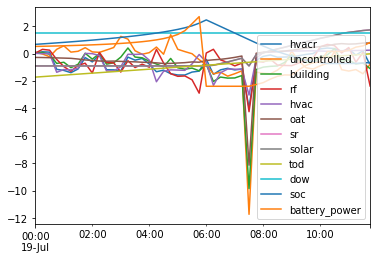

In [193]:
Xnorm.iloc[0:48].plot()

In [194]:
Xval=Xnorm[['oat','sr','tod','dow','uncontrolled']].dropna()
yval=Xnorm[['hvacr']].dropna()

In [195]:
CrossValScore(Xval,yval, LinearRegression())

0.5341521008536249

In [196]:
#Ridge deals well with multicolinearity, which we might have
alpha_values = np.linspace(1e-6, 1e0, 20)
RScores=[]
for a in alpha_values:
     RScores.append(CrossValScore(Xval,yval,Ridge(a)))
max(RScores)
#RScores

0.5362481475126216

In [197]:

LScores=[]
for a in alpha_values:
     LScores.append(CrossValScore(Xval, yval, Lasso(a)))
max(LScores)

0.5314426217015975

In [198]:
LR_Power = 8
Xpow = []

for i in range(LR_Power):
    Xnew=np.hstack([Xval**(j+1) for j in range(0,i+1)])
    Xpow.append(Xnew)
    Xn=pd.DataFrame(Xnew)
    print(CrossValScore(Xn,yval,Ridge(0.72)))

0.5338998968664566
0.5587959439696404
0.6073479044743301
0.610516785233257
0.6257048612611343
0.6278379731040049
0.6285056693291065
0.6298702308254784


/Users/lazlopaul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.54224e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/lazlopaul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=8.54705e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/lazlopaul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.32095e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/lazlopaul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.85885e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
/Users/lazlopaul/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAl

In [199]:
from sklearn.neighbors import KNeighborsRegressor

KScores=[]
LR_Power=5
for i in range(LR_Power):
    Xnew=np.hstack([Xval**(j+1) for j in range(0,i+1)])
    Xpow.append(Xnew)
    Xn=pd.DataFrame(Xnew)
    KScores.append(CrossValScore(Xval, yval, KNeighborsRegressor()))
print(KScores)

[0.6718346349516036, 0.6811385554034339, 0.6764046250633529, 0.6720800049828636, 0.6796979336028091]


In [200]:
Xval=X[['oat','sr','tod','dow','uncontrolled']].dropna()
yval=X[['hvacr']].dropna()

In [201]:
Xtrain=Xval.iloc[:-48]
Xtest=Xval.iloc[-48:]
ytrain=yval.iloc[:-48]
ytest=yval.iloc[-48:]

In [202]:
res = LinearRegression().fit(Xtrain,ytrain)
regy=res.predict(Xtest)

In [203]:
model=RandomForestRegressor()
result=model.fit(Xtrain, ytrain.values.ravel())
ypred=result.predict(Xtest)

In [204]:
Means['hvacr']

11257.583424104972

17.53898003613385
20.55861792635937
23.45693483569282


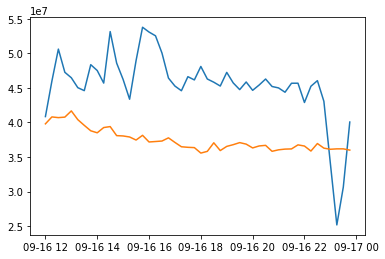

In [205]:
Xt=Xtest.copy()
Xt['pred']=regy*StdDevs['hvacr']+Means['hvacr']
Xt['test']=ytest*StdDevs['hvacr']+Means['hvacr']
plt.plot(ytest*StdDevs['hvacr']+Means['hvacr'])
plt.plot(Xt['pred'])
Xt['Epred']=Xt['pred'].cumsum()
Xt['E']=(ytest*StdDevs['hvacr']+Means['hvacr']).cumsum()
Error=abs(Xt['E'].iloc[-1]-Xt['Epred'].iloc[-1])/Xt['E'].iloc[-1]*100
print(Error)
print(mape(Xt['E'],Xt['Epred']))
print(mape(Xt['test'], Xt['pred']))

9.596348276781676
14.938398627049201
14.586016473368463


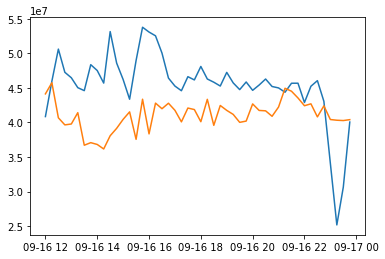

In [206]:
XtRF=Xtest.copy()
XtRF['pred']=ypred.reshape(-1,1)*StdDevs['hvacr']+Means['hvacr']
plt.plot(ytest*StdDevs['hvacr']+Means['hvacr'])
plt.plot(XtRF['pred'])
XtRF['Epred']=XtRF['pred'].cumsum()
XtRF['E']=(ytest*StdDevs['hvacr']+Means['hvacr']).cumsum()
Error=abs(XtRF['E'].iloc[-1]-XtRF['Epred'].iloc[-1])/XtRF['E'].iloc[-1]*100
print(Error)
print(mape(XtRF['E'],XtRF['Epred']))
print(mape(Xt['test'], XtRF['pred']))

,hvacr,uncontrolled,building,rf,hvac,oat,sr,solar,tod,dow,soc,battery_power
2020-07-19 00:00:00,11327.245948,24869.588688,36196.834635,5192.178104,6135.067844,60.682074,0.0,0.0,0.0,6.0,0.500000,3037.500000
2020-07-19 00:15:00,11629.342558,24609.757442,36239.100000,5522.244999,6107.097559,60.623867,0.0,0.0,15.0,6.0,0.506250,3125.543478
2020-07-19 00:30:00,11557.871673,24195.448995,35753.320668,5451.471304,6106.400368,60.532727,0.0,0.0,30.0,6.0,0.512681,3220.256917
2020-07-19 00:45:00,7980.634015,25327.847539,33308.481554,4628.373866,3352.260149,60.399778,0.0,0.0,45.0,6.0,0.519307,3322.487295
2020-07-19 01:00:00,7756.908696,25864.476602,33621.385298,4001.264045,3755.644651,60.292545,0.0,0.0,60.0,6.0,0.526144,3433.236872


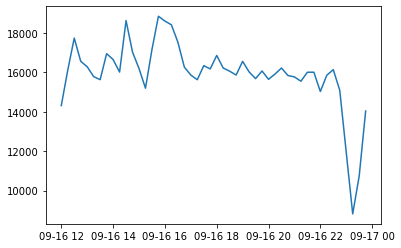

In [207]:
plt.plot(X['hvacr'].iloc[-48:])
X.head()

## Modeling Refrigeration and HVAC seperately

In [208]:
Xvals=Xp[['oat','sr','tod','dow','uncontrolled','soc','battery_power']].copy().dropna()
yhvac=Xp[['hvac']].copy().dropna()
yrf=Xp[['rf']].copy().dropna()

# Xtrain=Xvals[:-48]
# ytrhvac=yhvac[:-48]
# ytrain=yrf[:-48]

# Xtest=Xvals[-48:]
# ytest=yhvac[:-48]
# ytest=yrf[:-48]

2020-07-19 00:00:00
2020-07-20 23:45:00


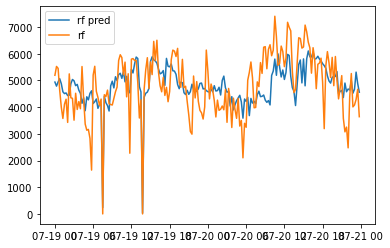

2020-07-21 00:00:00
2020-07-22 23:45:00


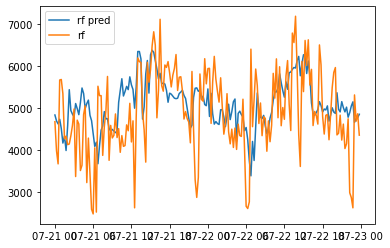

2020-07-23 00:00:00
2020-07-24 23:45:00


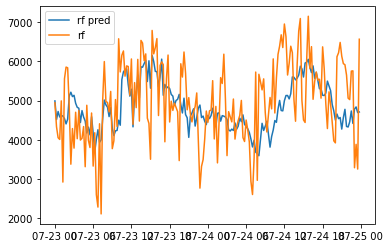

2020-07-25 00:00:00
2020-07-26 23:45:00


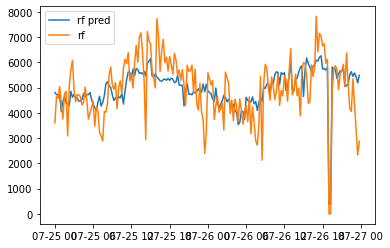

2020-07-27 00:00:00
2020-07-28 23:45:00


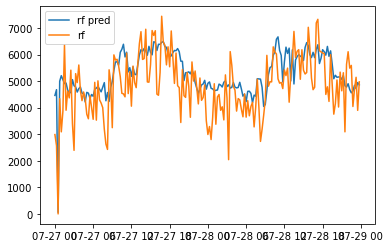

2020-07-29 00:00:00
2020-07-30 23:45:00


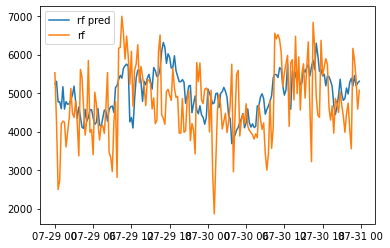

2020-07-31 00:00:00
2020-08-01 23:45:00


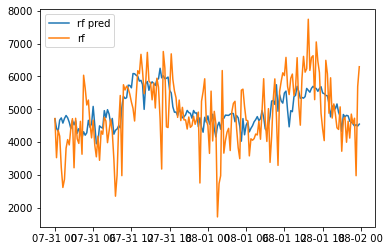

2020-08-02 00:00:00
2020-08-06 23:45:00


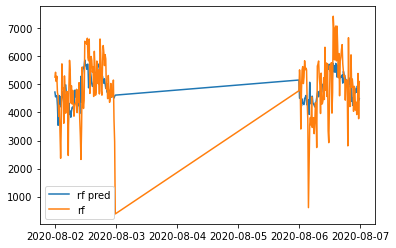

2020-08-08 00:00:00
2020-08-10 23:45:00


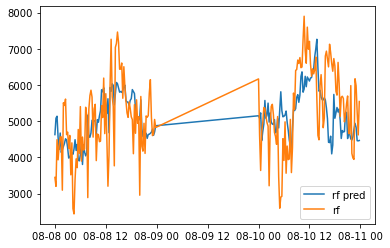

2020-08-12 00:15:00
2020-08-17 00:00:00


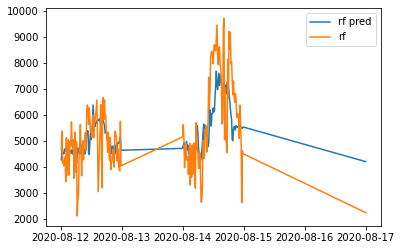

2020-08-17 00:15:00
2020-08-19 00:00:00


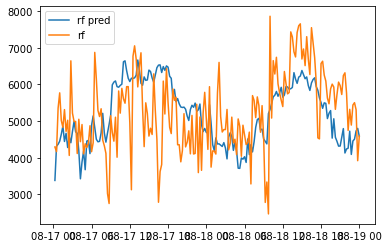

2020-08-19 00:15:00
2020-08-21 00:00:00


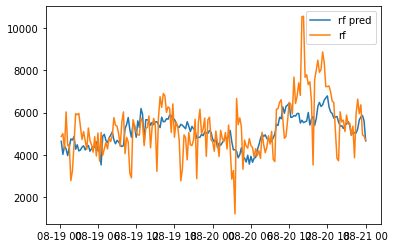

2020-08-21 00:15:00
2020-08-23 00:00:00


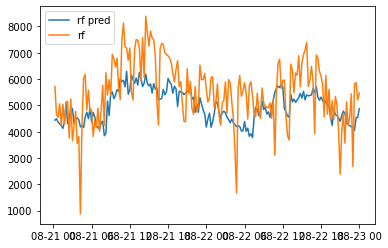

2020-08-23 00:15:00
2020-08-25 00:00:00


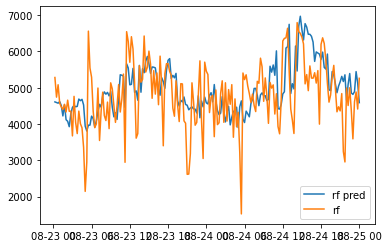

2020-08-25 00:15:00
2020-08-29 00:00:00


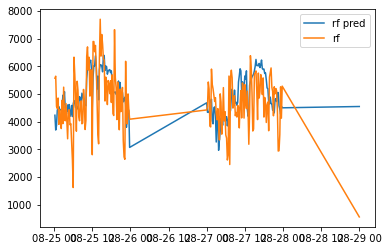

2020-08-29 00:15:00
2020-09-05 00:00:00


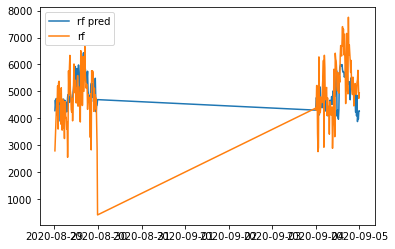

2020-09-05 00:15:00
2020-09-07 00:00:00


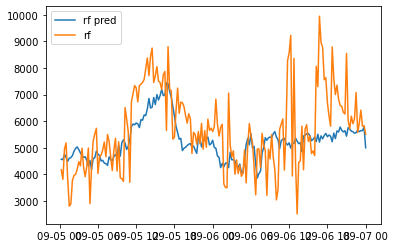

2020-09-07 00:15:00
2020-09-09 00:00:00


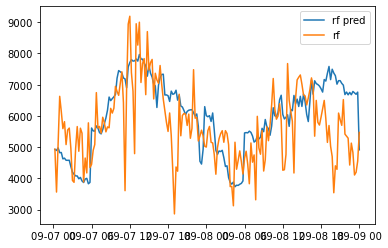

2020-09-09 00:15:00
2020-09-11 00:00:00


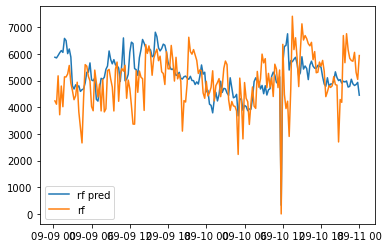

2020-09-11 00:15:00
2020-09-13 00:00:00


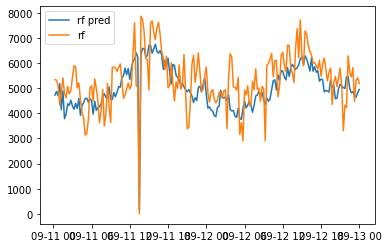

2020-09-13 00:15:00
2020-09-15 00:00:00


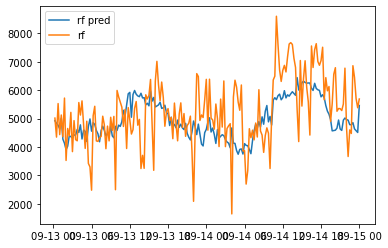

2020-09-15 00:15:00
2020-09-16 23:45:00


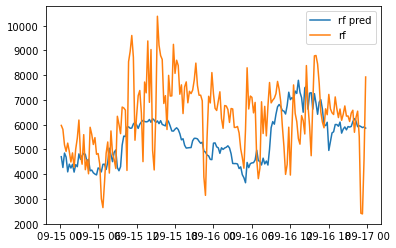

In [209]:
hvac_MAPE = []
rf_MAPE=[]
hvac_errors=[]
rf_errors=[]
for i in range(0,22):
    df=X.copy().iloc[i*divs:(i+1)*divs]
    df2=X.copy().iloc[0:i*divs].append(X.copy().iloc[(i+1)*divs:])
    #display(df2.head())
    hvac_MAPE, rf_MAPE, hvac_errors, rf_errors = crossVal_hvac_rf(df, df2)

https://www.sciencedirect.com/science/article/abs/pii/S0959652619301192

https://www.sciencedirect.com/science/article/abs/pii/S0196890415006925

https://www.sciencedirect.com/science/article/abs/pii/S0360544218321030

Didn't really read this one but looks like it could also be relavent: https://www.sciencedirect.com/science/article/abs/pii/S037877881731321X

### 